In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from datasets import load_dataset

# Load MNIST-M dataset
ds = load_dataset("Mike0307/MNIST-M")
train_data = ds['train']
test_data = ds['test']

X_train_m = np.array([np.array(image.resize((28, 28))) for image in train_data['image']])
y_train_m = np.array(train_data['label'])
X_test_m = np.array([np.array(image.resize((28, 28))) for image in test_data['image']])
y_test_m = np.array(test_data['label'])

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess MNIST
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = np.repeat(X_train, 3, axis=-1)  # Convert to 3 channels
X_test = np.repeat(X_test, 3, axis=-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Preprocess MNIST-M
X_train_m = X_train_m.astype(np.float32)/255
X_test_m = X_test_m.astype(np.float32)/255
y_train_m = to_categorical(y_train_m)
y_test_m = to_categorical(y_test_m)

print('MNIST shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('MNIST-M shapes:', X_train_m.shape, y_train_m.shape, X_test_m.shape, y_test_m.shape)

c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MNIST shapes: (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
MNIST-M shapes: (59001, 28, 28, 3) (59001, 10) (9001, 28, 28, 3) (9001, 10)


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(28, 28, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
features = Dense(128, activation='relu')(x)

feature_model = Model(inputs=input_layer, outputs=features)

feature_input = Input(shape=(128,))
x = Dropout(0.3)(feature_input)
predictions = Dense(10, activation='softmax')(x)
classifier_model = Model(inputs=feature_input, outputs=predictions)

classifier_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [3]:
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
feature_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,728 (944.25 KB)

 Trainable params: 241,280 (942.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

def coral_loss(source, target, scale_loss=1e4):
    batch_size = tf.cast(tf.shape(source)[0], tf.float32)
    d = tf.cast(tf.shape(source)[1], tf.float32)

    source_c = source - tf.reduce_mean(source, axis=0)
    target_c = target - tf.reduce_mean(target, axis=0)

    source_cov = tf.matmul(source_c, source_c, transpose_a=True) / (batch_size - 1.0)
    target_cov = tf.matmul(target_c, target_c, transpose_a=True) / (batch_size - 1.0)
    source_cov += tf.eye(tf.shape(source_cov)[0]) * 1e-5
    target_cov += tf.eye(tf.shape(target_cov)[0]) * 1e-5

    loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4.0 * d * d)
    return loss * scale_loss  


In [7]:
def coral_svm_loss(source_features, target_features, source_logits, source_labels, 
                  svm_lambda=1.0, coral_scale=1e4, margin=1.0):
    """
    Combined CORAL + SVM loss for domain adaptation.
    
    Args:
        source_features: Features from source domain (batch_size, feature_dim)
        target_features: Features from target domain (batch_size, feature_dim)
        source_logits: Classifier logits for source domain (batch_size, num_classes)
        source_labels: Ground truth labels (batch_size,)
        svm_lambda: Weight for SVM loss
        coral_scale: Scaling factor for CORAL loss
        margin: Margin for SVM hinge loss
    """
    # 1. CORAL Loss (Domain Alignment)
    batch_size = tf.cast(tf.shape(source_features)[0], tf.float32)
    d = tf.cast(tf.shape(source_features)[1], tf.float32)
    
    source_c = source_features - tf.reduce_mean(source_features, axis=0)
    target_c = target_features - tf.reduce_mean(target_features, axis=0)
    
    source_cov = tf.matmul(source_c, source_c, transpose_a=True) / (batch_size - 1.0)
    target_cov = tf.matmul(target_c, target_c, transpose_a=True) / (batch_size - 1.0)
    
    source_cov += tf.eye(tf.shape(source_cov)[0]) * 1e-5
    target_cov += tf.eye(tf.shape(target_cov)[0]) * 1e-5
    
    coral_loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4.0 * d * d)
    coral_loss *= coral_scale
    
    # 2. SVM Loss (Classification)
    num_classes = tf.shape(source_logits)[1]
    source_labels_onehot = tf.one_hot(tf.cast(source_labels, tf.int32), depth=num_classes)
    
    # Squared Hinge Loss (L2-SVM)
    svm_loss = tf.reduce_mean(
        tf.square(tf.maximum(0., margin - source_logits * source_labels_onehot))
    )
    
    return coral_loss + svm_lambda * svm_loss

In [8]:
def train_model(
    source_x, source_y, target_x, target_y=None,
    feature_model=None, classifier_model=None,
    epochs=10, batch_size=64, lambda_da=0.1, use_coral=True,
    validation_data=None, validation_samples=8000,
    early_stopping_patience=7, learning_rate=1e-3,
    gradient_clip=5.0, warmup_epochs=5
):
    # Initialize optimizer and metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    best_target_acc = 0.0
    patience_counter = 0
    
    # Create datasets for better performance
    source_ds = tf.data.Dataset.from_tensor_slices((source_x, source_y)) \
        .shuffle(len(source_x)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    target_ds = tf.data.Dataset.from_tensor_slices(target_x) \
        .shuffle(len(target_x)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        epoch_class_loss = tf.keras.metrics.Mean()
        epoch_da_loss = tf.keras.metrics.Mean()
        
        # Dynamic lambda scheduling
        current_lambda = 0.0 if not use_coral else min(lambda_da, lambda_da * (epoch / warmup_epochs))

        # Iterate through batches
        for (source_x_batch, source_y_batch), target_x_batch in zip(source_ds, target_ds):
            with tf.GradientTape() as tape:
                # Forward pass
                source_features = feature_model(source_x_batch, training=True)
                target_features = feature_model(target_x_batch, training=True)
                source_pred = classifier_model(source_features, training=True)
                
                # Loss calculation
                class_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(source_y_batch, source_pred)
                )
                
                if use_coral:
                    da_loss = coral_loss(source_features, target_features)
                else:
                    # Get pre-softmax logits (modify based on your model architecture)
                    source_logits = classifier_model(source_features, training=True)
                    da_loss = coral_svm_loss(
                        source_features, target_features,
                        source_logits, tf.argmax(source_y_batch, axis=1),
                        svm_lambda=1.0
                    )
                
                total_loss = class_loss + current_lambda * da_loss
            
            # Gradient update
            trainable_vars = (feature_model.trainable_variables + 
                            classifier_model.trainable_variables)
            gradients = tape.gradient(total_loss, trainable_vars)
            gradients, _ = tf.clip_by_global_norm(gradients, gradient_clip)
            optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Update metrics
            epoch_class_loss.update_state(class_loss)
            epoch_da_loss.update_state(da_loss)
        
        # Logging
        print(f"Class Loss: {epoch_class_loss.result():.4f}, "
              f"{'CORAL' if use_coral else 'without'} Loss: {epoch_da_loss.result():.4f}")
        
        # Validation
        if validation_data is not None:
            X_test_m, y_test_m = validation_data
            val_indices = tf.range(min(validation_samples, len(X_test_m)))
            
            # Calculate accuracies
            def calculate_accuracy(model, x, y, indices):
                features = model(x[indices], training=False)
                pred = classifier_model(features, training=False)
                return tf.reduce_mean(
                    tf.keras.metrics.categorical_accuracy(y[indices], pred)
                ).numpy()
            
            target_acc = calculate_accuracy(feature_model, X_test_m, y_test_m, val_indices)
            source_acc = calculate_accuracy(feature_model, source_x, source_y, 
                                          tf.range(min(validation_samples, len(source_x))))
            
            print(f"Source Acc: {source_acc:.4f}, Target Acc: {target_acc:.4f}")
            
            # Early stopping and model saving
            if target_acc > best_target_acc:
                best_target_acc = target_acc
                patience_counter = 0
                feature_model.save_weights('best_feature_model.weights.h5')
                classifier_model.save_weights('best_classifier_model.weights.h5')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
    
    return feature_model, classifier_model

In [9]:
print("Feature model output shape:", feature_model.output_shape)
print("Classifier input shape:", classifier_model.input_shape)

Feature model output shape: (None, 128)
Classifier input shape: (None, 128)


In [10]:
feature_model_coral , classifier_model_coral =train_model(
    source_x=X_train,        
    source_y=y_train,      
    target_x=X_train_m,        
    feature_model=feature_model,
    classifier_model=classifier_model,
    epochs=20,
    batch_size=64,
    lambda_da=0.5,            
    use_coral= False,            
    validation_data=(X_test_m, y_test_m)  
)


Epoch 1/20
Class Loss: 0.1169, without Loss: 1688.7415
Source Acc: 0.9620, Target Acc: 0.3868

Epoch 2/20
Class Loss: 0.0475, without Loss: 5342.8384
Source Acc: 0.9521, Target Acc: 0.4080

Epoch 3/20
Class Loss: 0.0376, without Loss: 8634.0625
Source Acc: 0.9929, Target Acc: 0.4151

Epoch 4/20
Class Loss: 0.0282, without Loss: 14244.0205
Source Acc: 0.9819, Target Acc: 0.4288

Epoch 5/20
Class Loss: 0.0263, without Loss: 28889.1133
Source Acc: 0.9735, Target Acc: 0.3913

Epoch 6/20
Class Loss: 0.0211, without Loss: 37830.8906
Source Acc: 0.9850, Target Acc: 0.4301

Epoch 7/20
Class Loss: 0.0202, without Loss: 63109.2070
Source Acc: 0.9916, Target Acc: 0.4146

Epoch 8/20
Class Loss: 0.0165, without Loss: 70698.2188
Source Acc: 0.9910, Target Acc: 0.4349

Epoch 9/20
Class Loss: 0.0152, without Loss: 123176.8047
Source Acc: 0.9934, Target Acc: 0.4266

Epoch 10/20
Class Loss: 0.0128, without Loss: 184191.4219
Source Acc: 0.9872, Target Acc: 0.4100

Epoch 11/20
Class Loss: 0.0134, without

In [11]:
from sklearn.metrics import accuracy_score, classification_report

target_features_coral = feature_model_coral(X_test_m, training=False)
y_pred_probs_coral = classifier_model_coral(target_features_coral, training=False)
y_pred_coral = np.argmax(y_pred_probs_coral, axis=1)

y_test_labels_coral = np.argmax(y_test_m, axis=1)  

accuracy = accuracy_score(y_test_labels_coral, y_pred_coral)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test_labels_coral, y_pred_coral))

Test Accuracy: 37.37%
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       878
           1       0.19      0.80      0.31      1016
           2       0.81      0.23      0.36       933
           3       0.92      0.19      0.31       908
           4       0.49      0.34      0.40       890
           5       0.80      0.31      0.45       807
           6       0.68      0.37      0.48       856
           7       0.51      0.44      0.47       914
           8       0.35      0.42      0.38       880
           9       0.79      0.19      0.31       919

    accuracy                           0.37      9001
   macro avg       0.59      0.37      0.39      9001
weighted avg       0.59      0.37      0.39      9001



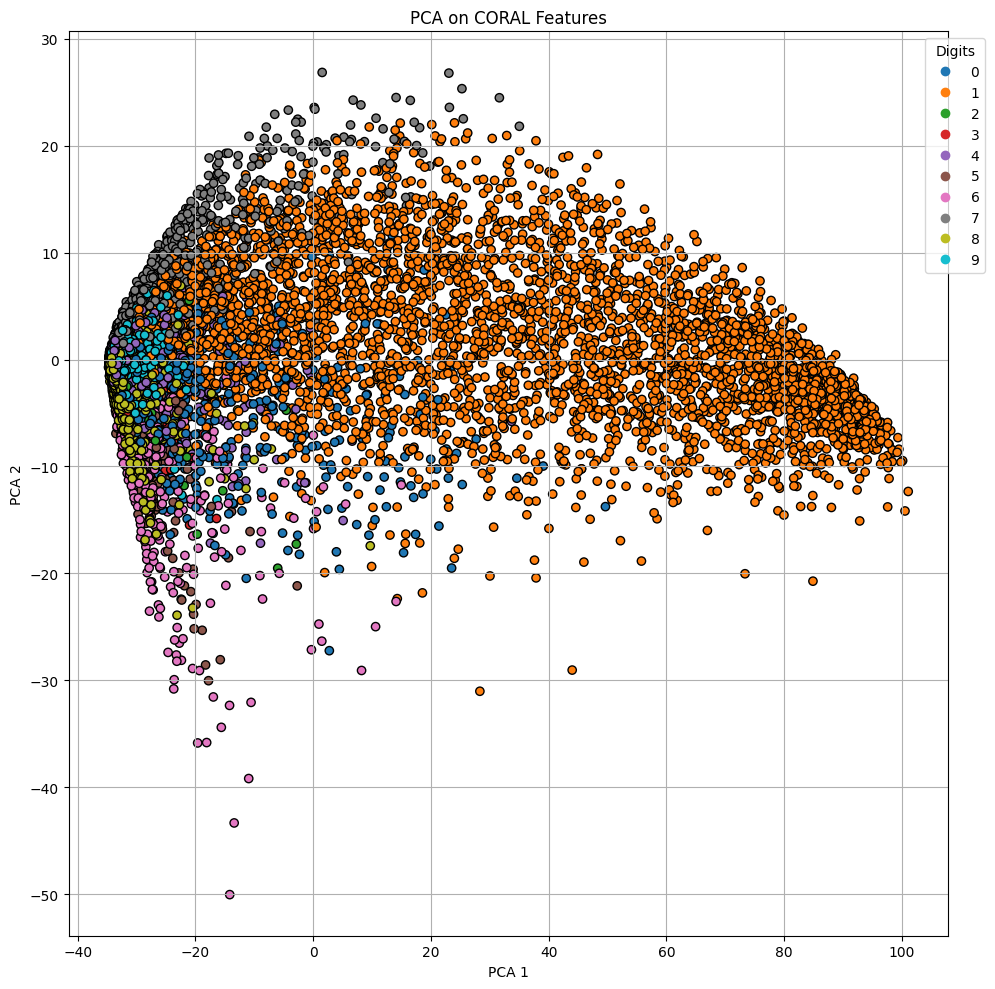

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure your test data is a NumPy array or eager tensor
X_test_m_np = X_test_m.numpy() if hasattr(X_test_m, 'numpy') else X_test_m

# Get actual feature outputs from model
target_features_coral = feature_model_coral(X_test_m_np, training=False)

# Convert to NumPy
if isinstance(target_features_coral, tf.Tensor):
    features = target_features_coral.numpy()
else:
    features = target_features_coral

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("PCA on CORAL Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


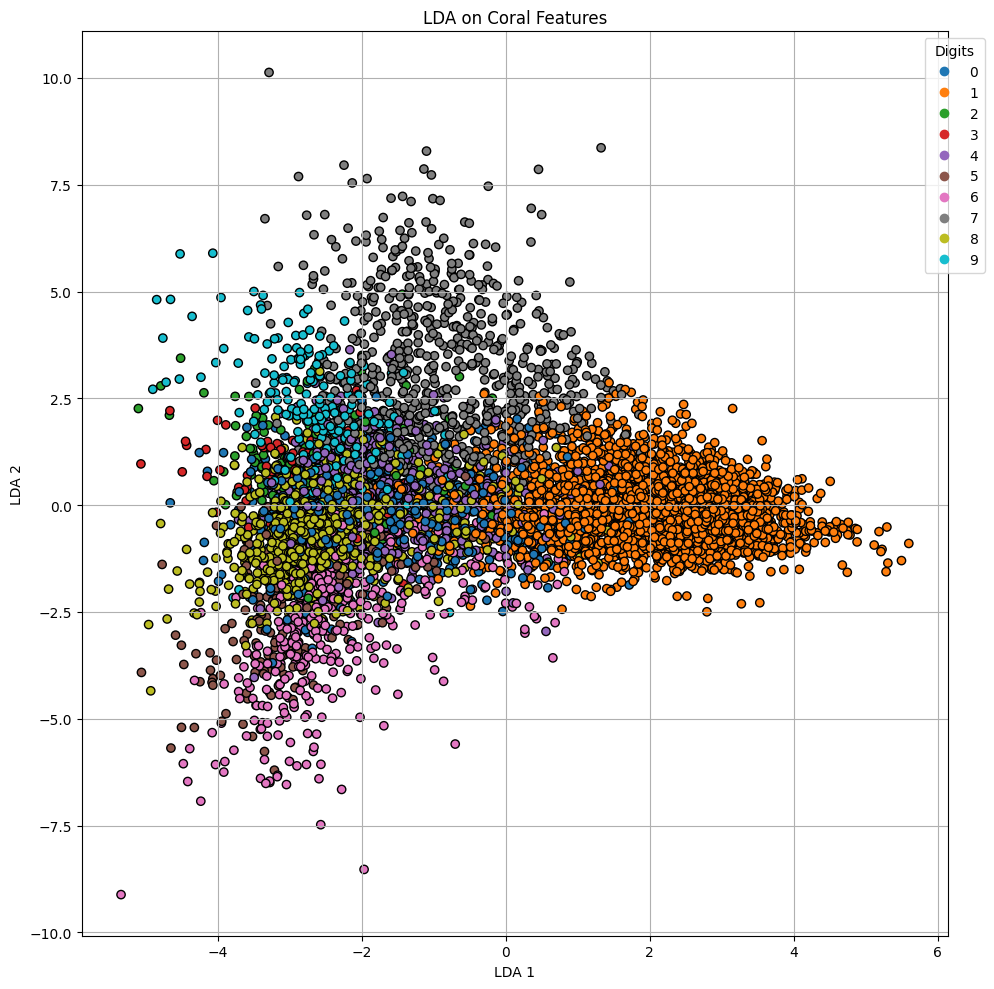

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda_result = lda.fit_transform(features, y_pred_coral)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(lda_result[:, 0], lda_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("LDA on Coral Features")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


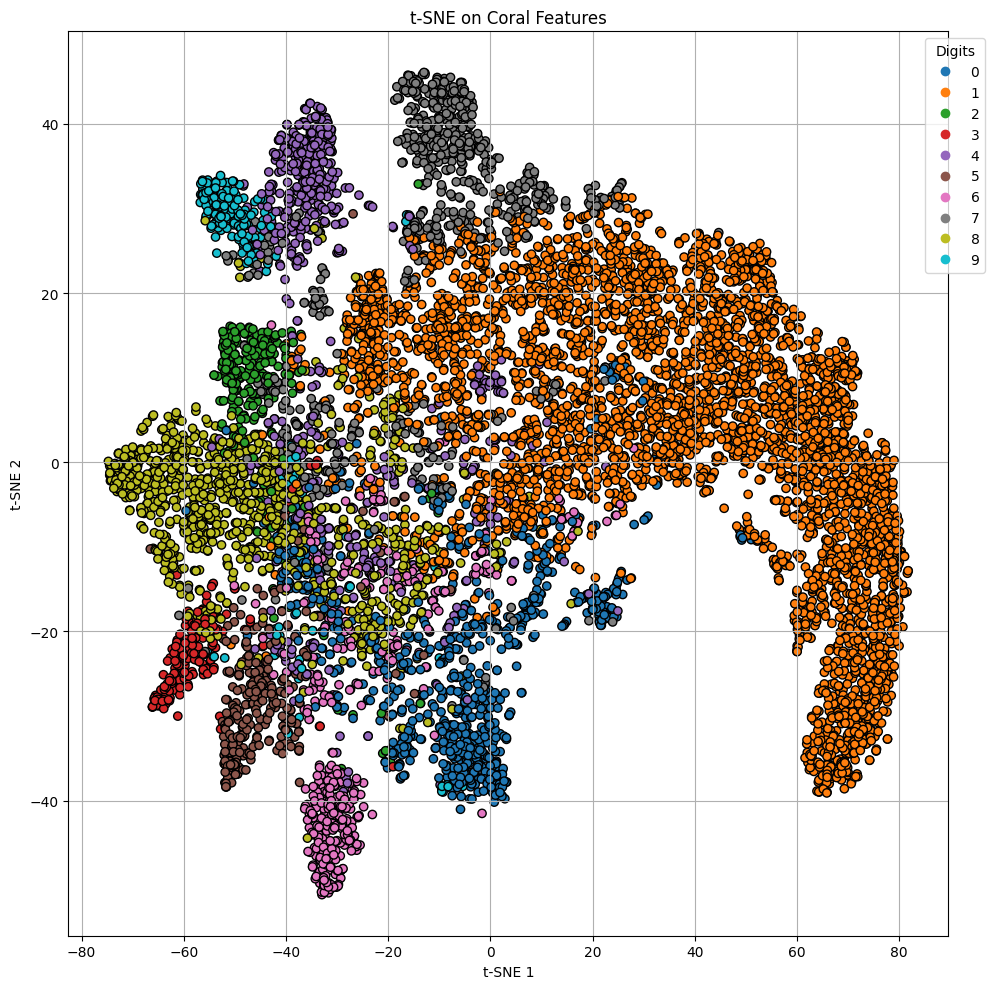

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_pred_coral, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("t-SNE on Coral Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


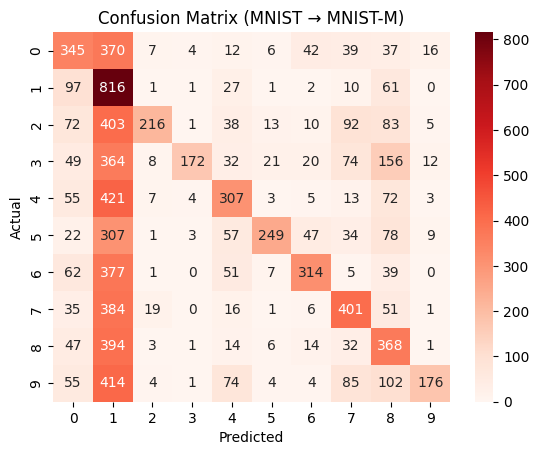

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if len(y_test_m.shape) > 1:
    y_test_m_labels = np.argmax(y_test_m, axis=1)
else:
    y_test_m_labels = y_test_m

if len(y_pred_coral.shape) > 1:
    y_pred_coral_labels = np.argmax(y_pred_coral, axis=1)
else:
    y_pred_coral_labels = y_pred_coral

cm = confusion_matrix(y_test_m_labels, y_pred_coral_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MNIST → MNIST-M)")
plt.show()


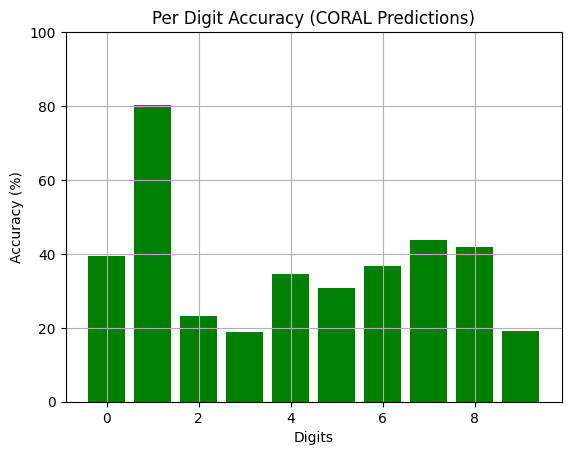

In [18]:
import numpy as np
import matplotlib.pyplot as plt

y_true = np.argmax(y_test_m, axis=1)
y_pred = y_pred_coral  

accuracies = []
for digit in range(10):
    idx = (y_true == digit)
    correct = (y_pred[idx] == digit).sum()
    total = idx.sum()
    accuracies.append(correct / total * 100)

plt.bar(range(10), accuracies, color='green')
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Per Digit Accuracy (CORAL Predictions)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()


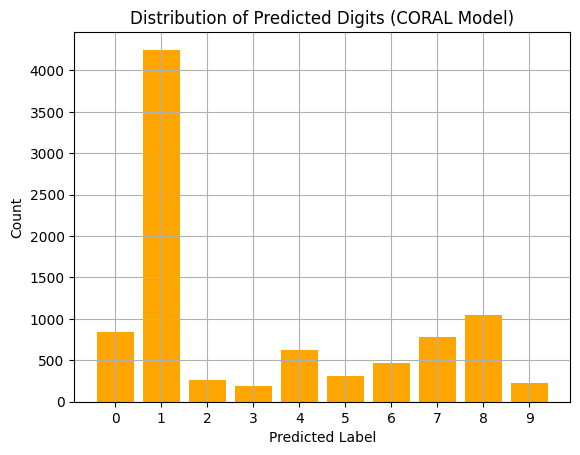

In [19]:
import numpy as np
import matplotlib.pyplot as plt

if len(y_pred_coral.shape) > 1:
    y_pred = np.argmax(y_pred_coral, axis=1)
else:
    y_pred = y_pred_coral  

plt.hist(y_pred, bins=np.arange(11) - 0.5, rwidth=0.8, color='orange')
plt.xticks(range(10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Distribution of Predicted Digits (CORAL Model)")
plt.grid(True)
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


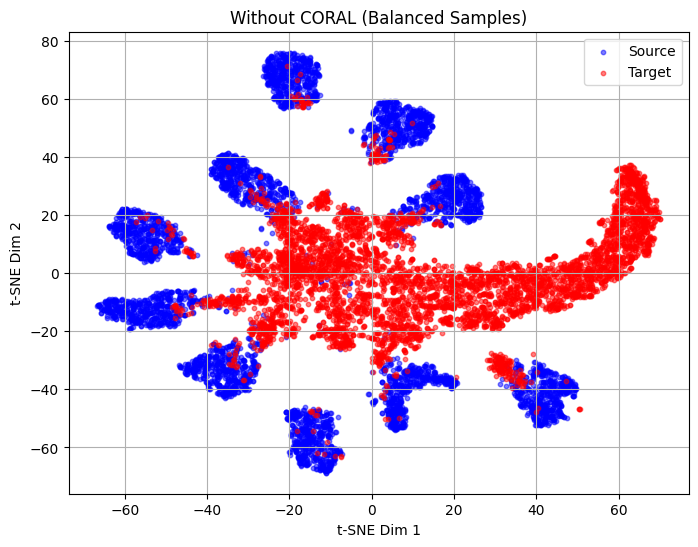

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_domain_alignment(source_features, target_features, title='Domain Alignment'):
  
    all_features = np.concatenate([source_features, target_features], axis=0)
    
    domain_labels = np.array([0]*len(source_features) + [1]*len(target_features))
    
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    reduced = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[domain_labels == 0, 0], reduced[domain_labels == 0, 1], 
                label='Source', alpha=0.5, s=10, c='blue')
    plt.scatter(reduced[domain_labels == 1, 0], reduced[domain_labels == 1, 1], 
                label='Target', alpha=0.5, s=10, c='red')
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(True)
    plt.show()

def balanced_sample(X, y, samples_per_class=700):
    selected = []
    for digit in range(10):
        indices = np.where(np.argmax(y, axis=1) == digit)[0]
        selected.extend(np.random.choice(indices, samples_per_class, replace=False))
    return X[selected], y[selected]

# Balanced sampling: 500 per class → 5000 total
X_src_bal, y_src_bal = balanced_sample(X_train, y_train, samples_per_class=500)
X_tgt_bal, y_tgt_bal = balanced_sample(X_train_m, y_train_m, samples_per_class=500)

features_src = feature_model.predict(X_src_bal)
features_tgt = feature_model.predict(X_tgt_bal)
plot_domain_alignment(features_src, features_tgt, title='Without CORAL (Balanced Samples)')
